# HTRU1 Batched Dataset Classification

We will use MiraPy for the classification of pulsars and non-pulsars in dataset released by HTRU1 survey. Following implementation is inspired by work done by Prof Anna Scaife using Pytorch [here](https://as595.github.io/HTRU1/).

We will begin with importing modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

from mirapy.data.load_dataset import load_htru1_data
from mirapy.classifiers.models import HTRU1Classifier
from mirapy.utils import accuracy_per_class

np.random.seed(42)

%matplotlib inline

Using TensorFlow backend.


Firstly, you need to dowload compressed HTRU1 batched dataset by running following commands:
```
$ wget http://www.jb.man.ac.uk/research/ascaife/htru1-batches-py.tar.gz
$ tar xvzf htru1-batches-py.tar.gz

```
To load HTRU1 batched dataset into numpy arrays, you can use data loader in [MiraPy](https://github.com/mirapy-org/mirapy) which is similar to that of CIFAR-10 dataset. The images are of size 32x32px cantaining 3 channels. You can read the details of the dataset in the above link.

In [2]:
x_train, y_train, x_test, y_test = load_htru1_data(data_dir='htru1-batches-py')

print("Train data: ", x_train.shape)
print("Train labels: ", y_train.shape)
print("Test data: ", x_test.shape)
print("Test labels: ", y_test.shape)

Train data:  (50000, 32, 32, 3)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test labels:  (10000,)


We will plot five sample training images:

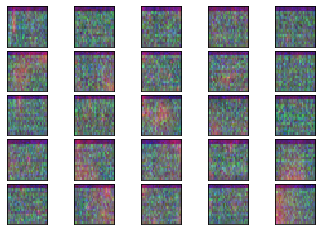

In [3]:
num_plot = 5

f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, x_train.shape[0])
        ax[m, n].imshow(x_train[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

It's time to setup our DL model.

In [4]:
batch_size = 128
num_classes = 2
epochs = 10
classes = ('pulsar', 'nonpulsar')
input_dim = (32, 32, 3)

The neural network requires categorial data during training therefore we will first convert numeric labeling to categorical.

Also, it is our foremost interest to normalize the values in order to achieve consistency in dynamic range for a set of images into a small range of fractional values.

In [5]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

We will load our proposed CNN model which consists of 2D convolution, max pooling, dropout (for regularization), and fully-connected layers. We use ReLU activation here but you are free to try other functions.

In [6]:
classifier = HTRU1Classifier(input_dim, activation='relu', padding='same', dropout=0.25, num_classes=num_classes)

This is what our classification model looks like:

In [7]:
classifier.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

Here, we use Adam optimizer which has often been obersved to outperform RMSprop.

In [8]:
adam = Adam(lr=0.001, beta_1=0.6)
classifier.compile(adam, loss='categorical_crossentropy')

The time has come to train our network!

In [9]:
classifier.train(x_train, y_train, epochs=epochs, batch_size=batch_size,
                 validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 19s 372us/step - loss: 0.0473 - val_loss: 0.0312
Epoch 2/10
50000/50000 [==============================] - 17s 335us/step - loss: 0.0256 - val_loss: 0.0290
Epoch 3/10
50000/50000 [==============================] - 17s 334us/step - loss: 0.0231 - val_loss: 0.0278
Epoch 4/10
50000/50000 [==============================] - 17s 334us/step - loss: 0.0208 - val_loss: 0.0251
Epoch 5/10
50000/50000 [==============================] - 17s 335us/step - loss: 0.0201 - val_loss: 0.0292
Epoch 6/10
50000/50000 [==============================] - 17s 334us/step - loss: 0.0209 - val_loss: 0.0259
Epoch 7/10
50000/50000 [==============================] - 17s 335us/step - loss: 0.0193 - val_loss: 0.0308
Epoch 8/10
50000/50000 [==============================] - 17s 336us/step - loss: 0.0179 - val_loss: 0.0322
Epoch 9/10
50000/50000 [==============================] - 17s 335us/step - loss: 0.0172 - val_

Below, we will predict classes for test set and print various evaluation metrics:

In [10]:
y_pred = classifier.predict(x_test)
y_pred = to_categorical(y_pred)

print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print(classification_report(y_test, y_pred))
print("Accuracy per class [pulsar, non-pulsar]:", accuracy_per_class(y_test, y_pred))

Accuracy: 99.34 %
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       199
           1       1.00      1.00      1.00      9801

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.95      0.88      0.91     10000
weighted avg       0.99      0.99      0.99     10000
 samples avg       0.99      0.99      0.99     10000

Accuracy per class [pulsar, non-pulsar]: [0.75376884 0.99826548]


## Handling Imbalanced Dataset

### Using class weights
One way to tackle imbalanced datasets is that assigning class weights while training so that the loss function becomes weighted average. We can assign the weights inversely propotional to the number of data points belonging to each class. We can also write it as-

w<sub>1</sub>n<sub>1</sub> = w<sub>2</sub>n<sub>2</sub>

The dataset contains 1194 true pulsars and 58806 non-pulsars in total. Accordingly, we will set class weights and retrain our network.

In [11]:
class_weight = {0: 0.98, 1: 0.02}

In [12]:
classifier.train(x_train, y_train, class_weight=class_weight,
                 epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 331us/step - loss: 0.0028 - val_loss: 0.0414
Epoch 2/10
50000/50000 [==============================] - 17s 333us/step - loss: 0.0022 - val_loss: 0.0867
Epoch 3/10
50000/50000 [==============================] - 17s 333us/step - loss: 0.0027 - val_loss: 0.0480
Epoch 4/10
50000/50000 [==============================] - 17s 336us/step - loss: 0.0024 - val_loss: 0.1576
Epoch 5/10
50000/50000 [==============================] - 17s 333us/step - loss: 0.0025 - val_loss: 0.0854
Epoch 6/10
50000/50000 [==============================] - 17s 334us/step - loss: 0.0022 - val_loss: 0.2184
Epoch 7/10
50000/50000 [==============================] - 17s 333us/step - loss: 0.0026 - val_loss: 0.0503
Epoch 8/10
50000/50000 [==============================] - 17s 333us/step - loss: 0.0025 - val_loss: 0.0355
Epoch 9/10
50000/50000 [==============================] - 17s 335us/step - loss: 0.0021 - val_

In [13]:
y_pred = classifier.predict(x_test)
y_pred = to_categorical(y_pred)

print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print(classification_report(y_test, y_pred))
print("Accuracy per class [pulsar, non-pulsar]:", accuracy_per_class(y_test, y_pred))

Accuracy: 98.17 %
              precision    recall  f1-score   support

           0       0.52      0.91      0.67       199
           1       1.00      0.98      0.99      9801

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.76      0.95      0.83     10000
weighted avg       0.99      0.98      0.98     10000
 samples avg       0.98      0.98      0.98     10000

Accuracy per class [pulsar, non-pulsar]: [0.91457286 0.98306295]


We can observe improvement in pulsar class accuracy by providing weights to each class during training. However, the overall accuracy has slightly decreased. There are other ways like 'oversampling' of minority class to handle imbalanced datasets.

### Dataset Citation

SPINN: a straightforward machine learning solution to the pulsar candidate selection problem V. Morello, E.D. Barr, M. Bailes, C.M. Flynn, E.F. Keane and W. van Straten, 2014, Monthly Notices of the Royal Astronomical Society, vol. 443, pp. 1651-1662 arXiv:1406:3627